# 引入观测天体：系外天体、太阳系天体（小行星）、人造卫星

In [1]:
from skyfield.api import wgs84, load
import datetime as dt
from pytz import timezone
from skyfield import almanac
import numpy as np
from skyfield.searchlib import find_discrete
from matplotlib import pyplot as plt

ts = load.timescale()
zone = timezone('Asia/Shanghai')
eph = load('de421.bsp')
sun, earth, moon = eph['sun'], eph['earth'], eph['moon']
bluffton = wgs84.latlon(+37.5359, +122.0496, elevation_m=110.0)
station = earth + bluffton

## 系外天体（参宿四 alf Ori -- Red Supergiant）

In [2]:
from skyfield.api import Star, load
from skyfield.data import hipparcos

with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

Exo_star = Star.from_dataframe(df.loc[27989])

## 太阳系天体——小行星

In [3]:
from skyfield.data import mpc
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

with load.open('MPCORB.excerpt.DAT') as f:
    minor_planets = mpc.load_mpcorb_dataframe(f)

print(minor_planets.shape[0], 'minor planets loaded')

12 minor planets loaded


In [4]:
minor_planets = minor_planets.set_index('designation', drop=False)
row = minor_planets.loc['(6) Hebe']
minorPlanet = sun + mpc.mpcorb_orbit(row, ts, GM_SUN)

## 人造卫星——问天实验舱

In [5]:
stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
print('Loaded', len(satellites), 'satellites')

Loaded 51 satellites


In [6]:
by_name = {sat.name: sat for sat in satellites}
satellite = by_name['CSS (WENTIAN)']
print(satellite)

CSS (WENTIAN) catalog #53239 epoch 2022-12-06 11:54:41 UTC


## 观测列表

In [7]:
print("系外天体   ", Exo_star)
print("小行星   ", minorPlanet)
print("人造卫星   ", satellite)

系外天体    Star(ra=88.79287161000002, dec=7.40703634, ra_mas_per_year=27.33, dec_mas_per_year=10.86, parallax_mas=7.63, epoch=2448349.0625)
小行星    Sum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
 _KeplerOrbit 10 SUN -> str
人造卫星    CSS (WENTIAN) catalog #53239 epoch 2022-12-06 11:54:41 UTC


In [8]:
date = ts.utc(2022, 12, 9, 16)
astrometric1 = earth.at(date).observe(Exo_star)
ra1, dec1, distance1 = astrometric1.radec()
print(ra1)
print(dec1)
ra2, dec2, distance2 = earth.at(date).observe(minorPlanet).radec()
print(ra2)
print(dec2)

05h 55m 10.35s
+07deg 24' 25.7"
08h 57m 34.51s
+08deg 01' 41.9"


# 天文晨昏

In [9]:
now = zone.localize(dt.datetime(2022, 12, 9))
midnight = now.replace(hour=0, minute=0, second=0, microsecond=0)
next_midnight = midnight + dt.timedelta(days=2)

ts = load.timescale()
t0 = ts.from_datetime(midnight)
t1 = ts.from_datetime(next_midnight)
eph = load('de421.bsp')
bluffton = wgs84.latlon(+37.5359, +122.0496, elevation_m=110.0)
f = almanac.dark_twilight_day(eph, bluffton)
times, events = almanac.find_discrete(t0, t1, f)

previous_e = f(t0).item()
for t, e in zip(times, events):
    tstr = str(t.astimezone(zone))[:16]
    if previous_e < e:
        print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
    else:
        print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
    previous_e = e

2022-12-09 05:20   Astronomical twilight starts
2022-12-09 05:52   Nautical twilight starts
2022-12-09 06:25   Civil twilight starts
2022-12-09 06:54   Day starts
2022-12-09 16:33   Day ends
2022-12-09 17:02   Civil twilight ends
2022-12-09 17:35   Nautical twilight ends
2022-12-09 18:06   Astronomical twilight ends
2022-12-10 05:21   Astronomical twilight starts
2022-12-10 05:53   Nautical twilight starts
2022-12-10 06:26   Civil twilight starts
2022-12-10 06:55   Day starts
2022-12-10 16:33   Day ends
2022-12-10 17:02   Civil twilight ends
2022-12-10 17:35   Nautical twilight ends
2022-12-10 18:07   Astronomical twilight ends


In [10]:
As_end = times[7]
As_sta = times[8]
print(As_end.astimezone(zone))
print(As_sta.astimezone(zone))

2022-12-09 18:06:51.319275+08:00
2022-12-10 05:21:36.193708+08:00


# 观测时间计算

## 人造卫星--Skyfield提供了现成的方法

In [11]:
t, events = satellite.find_events(bluffton, As_end, As_sta, altitude_degrees=30.0)
for ti, event in zip(t, events):
    name = ('rise above 30°', 'culminate', 'set below 30°')[event]
    print(ti.astimezone(zone), name)
time_satellite = t

2022-12-09 18:21:44.071543+08:00 rise above 30°
2022-12-09 18:23:07.411425+08:00 culminate
2022-12-09 18:24:37.914656+08:00 set below 30°


### 卫星在日光照射下吗？

In [12]:
sunlit = satellite.at(time_satellite).is_sunlit(eph)
print(sunlit)

[ True False False]


In [13]:
for ti, sunlit_i in zip(time_satellite, sunlit):
    print('{}  {} is in {}'.format(
        ti.astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'),
        satellite.name,
        'sunlight' if sunlit_i else 'shadow',
    ))

2022-12-09 18:21:44  CSS (WENTIAN) is in sunlight
2022-12-09 18:23:07  CSS (WENTIAN) is in shadow
2022-12-09 18:24:37  CSS (WENTIAN) is in shadow


## 系外天体、太阳系内小行星

### 一些函数的定义，用于计算高度角达30°，与月亮的角距，可视化等

In [14]:
def twi_30(t):
    e = station.at(t)
    app = e.observe(target).apparent()
    alt, az, distance = app.altaz()
    return alt.radians >= np.pi/6

def moon_5de(t):
    e = station.at(t)
    t = e.observe(target).apparent()
    m = e.observe(moon).apparent()
    return t.separation_from(m).degrees <= 5

def moon_angle(target, t):
    e = station.at(t)
    t = e.observe(target).apparent()
    m = e.observe(moon).apparent() 
    return t.separation_from(m).degrees

def TimeSequence(starttime, endtime):
    y = starttime.utc.year
    month = starttime.utc.month
    d = starttime.utc.day
    h = starttime.utc.hour
    m = starttime.utc.minute
    s = starttime.utc.second
    
    st = starttime.tdb
    et = endtime.tdb
    minutenum = (et - st)/(60/86400)
    #print(minutenum)
    minutelist = np.arange(m, m + minutenum + 1, 1)
    #print(minutelist)
    #print(month)
    Timelist = ts.utc(y, month, d, h, minutelist)
    
    return Timelist

def TimeSequenceSencond(starttime, endtime):
    y = starttime.utc.year
    month = starttime.utc.month
    d = starttime.utc.day
    h = starttime.utc.hour
    m = starttime.utc.minute
    s = starttime.utc.second
    
    st = starttime.tdb
    et = endtime.tdb
    secondnum= (et - st)/(1/86400)
    #print(minutenum)
    secondlist = np.arange(s, s + secondnum + 1, 1)
    #print(minutelist)
    #print(month)
    Timelist = ts.utc(y, month, d, h, m, secondlist)
    
    return Timelist

### 高度角达30°

In [15]:
# 系外行星
twi_30.step_days = 1/86400
target = Exo_star
t, values = find_discrete(As_end, As_sta, twi_30)
twi_ExoStar = t
for ti, ei in zip(t, values):
    print(ti.astimezone(zone), ei)
twi_ExoStar = np.array(twi_ExoStar)

2022-12-09 20:44:52.823308+08:00 1
2022-12-10 04:24:22.735566+08:00 0


In [16]:
# 小行星
target = minorPlanet
t, values = find_discrete(As_end, As_sta, twi_30)
twi_minorPlanet = t
for ti, ei in zip(t, values):
    print(ti.astimezone(zone), ei)
twi_minorPlanet = np.array(twi_minorPlanet)

2022-12-09 23:45:01.878459+08:00 1


### 上中天

In [17]:
# 系外行星
f = almanac.meridian_transits(eph, Exo_star, bluffton)
t, y = almanac.find_discrete(As_end, As_sta, f)
for ti, ei in zip(t, y):
    print(ti.astimezone(zone), ei)
    if ei == 1:
        cul_ExoStar = ti

2022-12-10 00:34:37.786397+08:00 1


In [18]:
# 小行星
f = almanac.meridian_transits(eph, minorPlanet, bluffton)
t, y = almanac.find_discrete(As_end, As_sta, f)
for ti, ei in zip(t, y):
    print(ti.astimezone(zone), ei)
    if ei == 1:
        cul_minorPlanet = ti

2022-12-10 03:36:30.527005+08:00 1


### 目标与月亮的角距会小于5°吗？

In [19]:
# 系外行星
moon_5de.step_days = 1/86400
target = Exo_star
t, values = find_discrete(As_end, As_sta, moon_5de)
for ti, ei in zip(t, values):
    print(ti.astimezone(zone), ei)

In [20]:
# 小行星
moon_5de.step_days = 1/86400
target = minorPlanet
t, values = find_discrete(As_end, As_sta, moon_5de)
for ti, ei in zip(t, values):
    print(ti.astimezone(zone), ei)

In [21]:
# 人造卫星
moon_5de.step_days = 1/86400
target = earth + satellite
t, values = find_discrete(As_end, As_sta, moon_5de)
for ti, ei in zip(t, values):
    print(ti.astimezone(zone), ei)

## 可观测时段与最佳观测时间

In [22]:
print('Object: alf Ori')
print(twi_ExoStar[0].astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'rise above 30°')
print(cul_ExoStar.astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'culminate')
print(twi_ExoStar[1].astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'set below 30°')
print('Object: Hebe')
print(twi_minorPlanet[0].astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'rise above 30°')
print(cul_ExoStar.astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'culminate')
print(As_sta.astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'Astronomical twilight starts')
print('Object: CSS(WENTIAN)')
print(time_satellite[0].astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'rise above 30°')
print(time_satellite[1].astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'culminate')
print(time_satellite[2].astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'), 'set below 30°')

Object: alf Ori
2022-12-09 20:44:52 rise above 30°
2022-12-10 00:34:37 culminate
2022-12-10 04:24:22 set below 30°
Object: Hebe
2022-12-09 23:45:01 rise above 30°
2022-12-10 00:34:37 culminate
2022-12-10 05:21:36 Astronomical twilight starts
Object: CSS(WENTIAN)
2022-12-09 18:21:44 rise above 30°
2022-12-09 18:23:07 culminate
2022-12-09 18:24:37 set below 30°


# 可观测时间段人造卫星历表

In [23]:
def sat_eph(t):
    difference = satellite - bluffton
    topocentric = difference.at(t)
    alt, az, distance = topocentric.altaz()
    ra, dec, distance = topocentric.radec() 
    return alt, az, ra, dec

In [24]:
TimeList_eph = TimeSequenceSencond(time_satellite[0], time_satellite[2])

In [25]:
WenTian_eph = {}
for t in TimeList_eph:
    alt, az, ra, dec = sat_eph(t)
    WenTian_eph[t.astimezone(zone).strftime('%H:%M:%S')] = (alt, az, ra, dec)

In [26]:
print(WenTian_eph)

{'18:21:44': (<Angle 30deg 02' 21.9">, <Angle 280deg 54' 33.2">, <Angle 18h 58m 39.18s>, <Angle +25deg 44' 55.8">), '18:21:45': (<Angle 30deg 22' 17.0">, <Angle 280deg 46' 18.4">, <Angle 19h 00m 12.64s>, <Angle +25deg 48' 42.2">), '18:21:46': (<Angle 30deg 42' 29.4">, <Angle 280deg 37' 51.8">, <Angle 19h 01m 47.62s>, <Angle +25deg 52' 27.6">), '18:21:47': (<Angle 31deg 02' 59.3">, <Angle 280deg 29' 13.0">, <Angle 19h 03m 24.13s>, <Angle +25deg 56' 11.7">), '18:21:48': (<Angle 31deg 23' 47.0">, <Angle 280deg 20' 21.6">, <Angle 19h 05m 02.21s>, <Angle +25deg 59' 54.3">), '18:21:49': (<Angle 31deg 44' 53.0">, <Angle 280deg 11' 17.0">, <Angle 19h 06m 41.89s>, <Angle +26deg 03' 35.4">), '18:21:50': (<Angle 32deg 06' 17.5">, <Angle 280deg 01' 58.8">, <Angle 19h 08m 23.21s>, <Angle +26deg 07' 14.8">), '18:21:51': (<Angle 32deg 28' 01.0">, <Angle 279deg 52' 26.6">, <Angle 19h 10m 06.20s>, <Angle +26deg 10' 52.3">), '18:21:52': (<Angle 32deg 50' 03.7">, <Angle 279deg 42' 39.8">, <Angle 19h 11m 

In [27]:
with open('WenTian_Visbility_Eph.txt', 'w') as f:
    f.write('2022-12-9   altitude       azimuth         right ascension   declination \n')
    for t in TimeList_eph:
        alt, az, ra, dec = sat_eph(t)
        lines = [t.astimezone(zone).strftime('%H:%M:%S'), str(alt), str(az), str(ra), str(dec)]
        for line in lines:
            f.write(line)
            f.write('   ')
        f.write('\n')

# 可视化

In [28]:
timelist = TimeSequence(As_end, As_sta)
timelist_tdb = []
for ti in timelist:
    timelist_tdb.append(ti.tdb)
timelist_tdb = np.array(timelist_tdb )

In [29]:
def alt(target, t):
    e = station.at(t)
    app = e.observe(target).apparent()
    alt, az, distance = app.altaz()
    return alt

def alt_time(target, timelist):
    alts = []
    for t in timelist:
        d = alt(target, t).radians * 180 /np.pi
        alts.append(d)
    return np.array(alts)

## 系外天体与太阳系天体

In [30]:
alt_moon = alt_time(moon, timelist)
alt_ExoStar = alt_time(Exo_star, timelist)
angle_ExoStar_moon = []
for t in timelist:
    angle_ExoStar_moon.append(moon_angle(Exo_star, t))
angle_ExoStar_moon = np.array(angle_ExoStar_moon)

alt_MiminorPlanet = alt_time(minorPlanet, timelist)
angle_MiminorPlanet_moon = []
for t in timelist:
    angle_MiminorPlanet_moon.append(moon_angle(minorPlanet, t))
angle_MiminorPlanet_moon = np.array(angle_MiminorPlanet_moon)

In [31]:
# 横坐标刻度与标签
ae = As_end.astimezone(zone).hour
ast = As_sta.astimezone(zone).hour
t0 = As_end.astimezone(zone).replace(minute = 0, second=0, microsecond=0)
t1 = As_sta.astimezone(zone).replace(hour = ast + 1, minute = 0, second=0, microsecond=0)
T0 = ts.from_datetime(t0)
T1 = ts.from_datetime(t1)
txtick = np.arange(T0.tdb, T1.tdb + 3600/86400, 3600/86400)
sxtick = np.append(np.arange(ae, 25, 1), np.arange(1, ast+2, 1))
print(txtick)
print(sxtick)

[2459922.9174674  2459922.95913407 2459923.00080073 2459923.0424674
 2459923.08413407 2459923.12580073 2459923.1674674  2459923.20913406
 2459923.25080073 2459923.2924674  2459923.33413406 2459923.37580073
 2459923.4174674 ]
[18 19 20 21 22 23 24  1  2  3  4  5  6]


Text(0.5, 0.98, 'Object: alf Ori (05h 55m 10.35s  +07deg 24\' 25.7")')

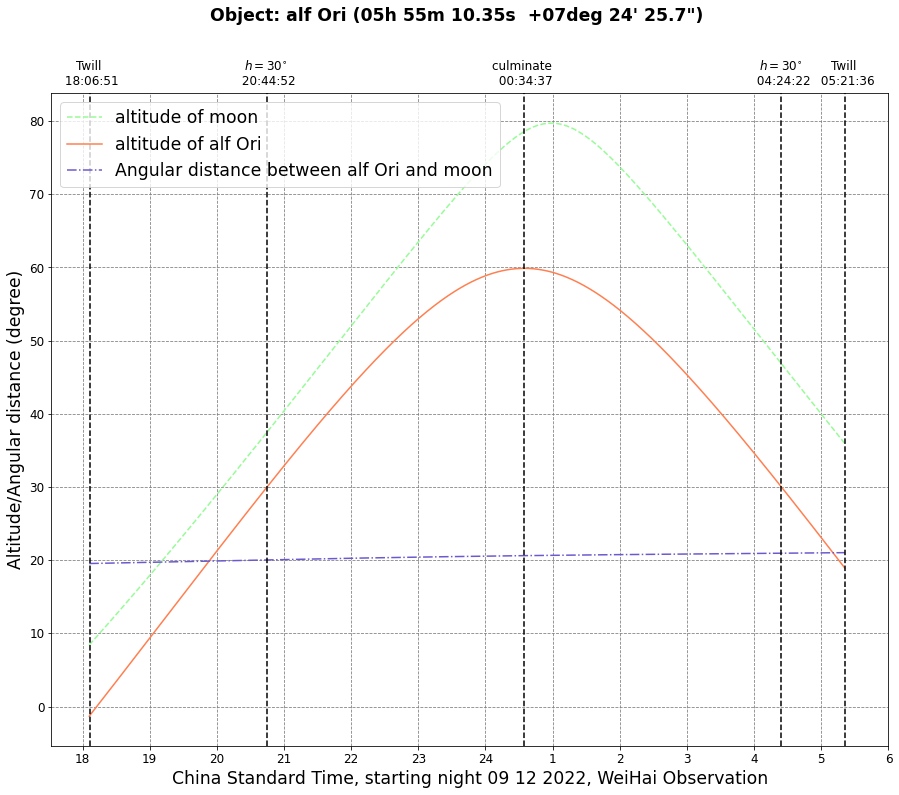

In [32]:
fig, ax = plt.subplots(figsize=(15, 12))
    
ax.plot(timelist_tdb, alt_moon, ls='--', c='palegreen', label='altitude of moon')
ax.plot(timelist_tdb, alt_ExoStar, ls='-', c='coral', label='altitude of alf Ori')
ax.plot(timelist_tdb, angle_ExoStar_moon, ls='-.', c='slateblue', label='Angular distance between alf Ori and moon')
ax.set_xticks(txtick, sxtick)
ax.grid(ls='--',c='grey')
ax.legend(loc='upper left', fontsize='xx-large')

ax.axvline(As_end.tdb, color='black', ls='--')
ax.axvline(As_sta.tdb, color='black', ls='--')
string = r'$h = 30^{\circ}$'
for t in twi_ExoStar:
    ax.axvline(t.tdb, color='black', ls='--')
    ax.text(t.tdb, 85, "{} \n {}".format(string, t.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.axvline(cul_ExoStar.tdb, color='black', ls='--')

ax.text(As_end.tdb, 85, "Twill \n {}".format(As_end.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.text(As_sta.tdb, 85, "Twill \n {}".format(As_sta.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.text(cul_ExoStar.tdb, 85, "culminate \n {}".format(cul_ExoStar.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

ax.set_xlabel('China Standard Time, starting night 09 12 2022, WeiHai Observation', fontsize='xx-large')
ax.set_ylabel('Altitude/Angular distance (degree)', fontsize='xx-large')

fig.suptitle('Object: alf Ori ({})'.format(str(ra1)+'  '+str(dec1)), fontsize='xx-large', fontweight='bold')

Text(0.5, 0.98, 'Object: Hebe (08h 57m 34.51s  +08deg 01\' 41.9")')

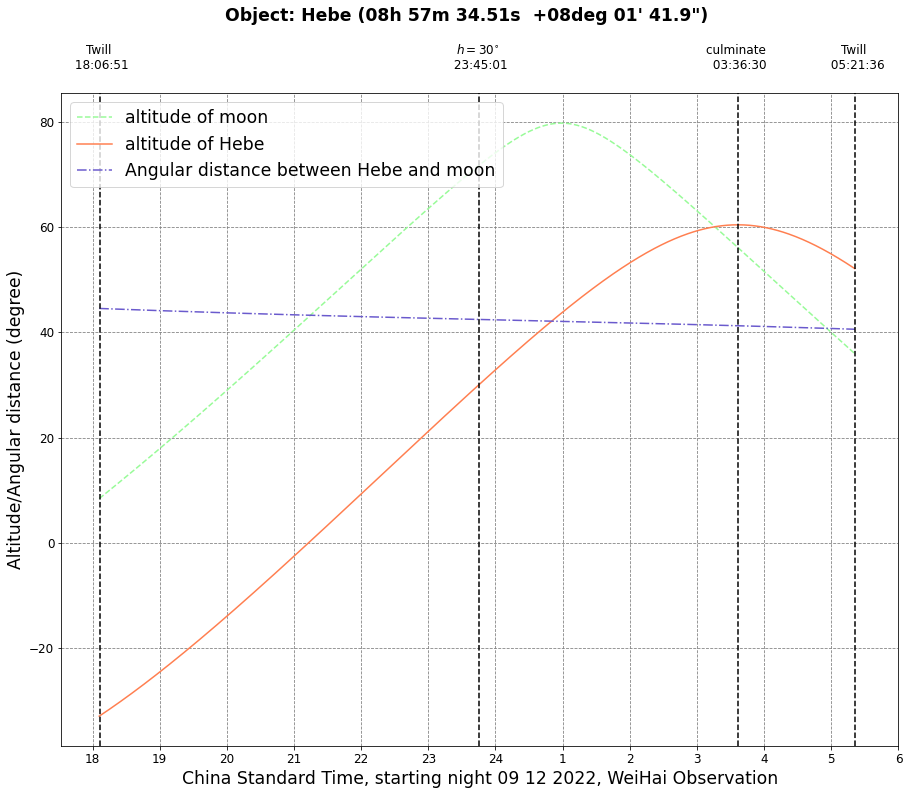

In [33]:
fig, ax = plt.subplots(figsize=(15, 12))
    
ax.plot(timelist_tdb, alt_moon, ls='--', c='palegreen', label='altitude of moon')
ax.plot(timelist_tdb, alt_MiminorPlanet, ls='-', c='coral', label='altitude of Hebe')
ax.plot(timelist_tdb, angle_MiminorPlanet_moon, ls='-.', c='slateblue', label='Angular distance between Hebe and moon')
ax.set_xticks(txtick, sxtick)
ax.grid(ls='--',c='grey')
ax.legend(loc='upper left', fontsize='xx-large')

ax.axvline(As_end.tdb, color='black', ls='--')
ax.axvline(As_sta.tdb, color='black', ls='--')
string = r'$h = 30^{\circ}$'
for t in twi_minorPlanet:
    ax.axvline(t.tdb, color='black', ls='--')
    ax.text(t.tdb, 90, "{} \n {}".format(string, t.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.axvline(cul_minorPlanet.tdb, color='black', ls='--')

ax.text(As_end.tdb, 90, "Twill \n {}".format(As_end.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.text(As_sta.tdb, 90, "Twill \n {}".format(As_sta.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.text(cul_minorPlanet.tdb, 90, "culminate \n {}".format(cul_minorPlanet.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

ax.set_xlabel('China Standard Time, starting night 09 12 2022, WeiHai Observation', fontsize='xx-large')
ax.set_ylabel('Altitude/Angular distance (degree)', fontsize='xx-large')

fig.suptitle('Object: Hebe ({})'.format(str(ra2)+'  '+str(dec2)), fontsize='xx-large', fontweight='bold')

## 系外天体与小行星观测时间——结果验证

.[Object Visibility – STARALT](http://catserver.ing.iac.es/staralt/index.php)

[![zgg8QP.png](https://s1.ax1x.com/2022/12/07/zgg8QP.png)](https://imgse.com/i/zgg8QP)

## 人造卫星

In [34]:
t, events = satellite.find_events(bluffton, As_end, As_sta, altitude_degrees=0.0)
for ti, event in zip(t, events):
    name = ('rise above horizon', 'culminate', 'set below horizon')[event]
    print(ti.astimezone(zone), name)
twi_cul_satellite = t

2022-12-09 18:17:52.956040+08:00 rise above horizon
2022-12-09 18:23:07.411425+08:00 culminate
2022-12-09 18:28:22.233978+08:00 set below horizon
2022-12-09 19:55:14.297762+08:00 rise above horizon
2022-12-09 19:59:39.665544+08:00 culminate
2022-12-09 20:04:06.476891+08:00 set below horizon


In [35]:
sunlit = satellite.at(twi_cul_satellite).is_sunlit(eph)
print(sunlit)

[ True False False False False False]


In [36]:
for ti, sunlit_i in zip(twi_cul_satellite, sunlit):
    print('{}  {} is in {}'.format(
        ti.astimezone(zone).strftime('%Y-%m-%d %H:%M:%S'),
        satellite.name,
        'sunlight' if sunlit_i else 'shadow',
    ))

2022-12-09 18:17:52  CSS (WENTIAN) is in sunlight
2022-12-09 18:23:07  CSS (WENTIAN) is in shadow
2022-12-09 18:28:22  CSS (WENTIAN) is in shadow
2022-12-09 19:55:14  CSS (WENTIAN) is in shadow
2022-12-09 19:59:39  CSS (WENTIAN) is in shadow
2022-12-09 20:04:06  CSS (WENTIAN) is in shadow


In [37]:
TimeList = TimeSequenceSencond(As_end, twi_cul_satellite[5])
TimeList_tdb = []
for ti in TimeList:
    TimeList_tdb.append(ti.tdb)
TimeList_tdb = np.array(TimeList_tdb)

In [38]:
alt_satellite = alt_time(earth + satellite, timelist)
alt_satellite1 = alt_time(earth + satellite, TimeList)
angle_satellite_moon = []
for t in timelist:
    angle_satellite_moon.append(moon_angle(earth + satellite, t))
angle_satellite_moon = np.array(angle_satellite_moon)

Text(0.5, 0.98, 'Object: CSS (WENTIAN)')

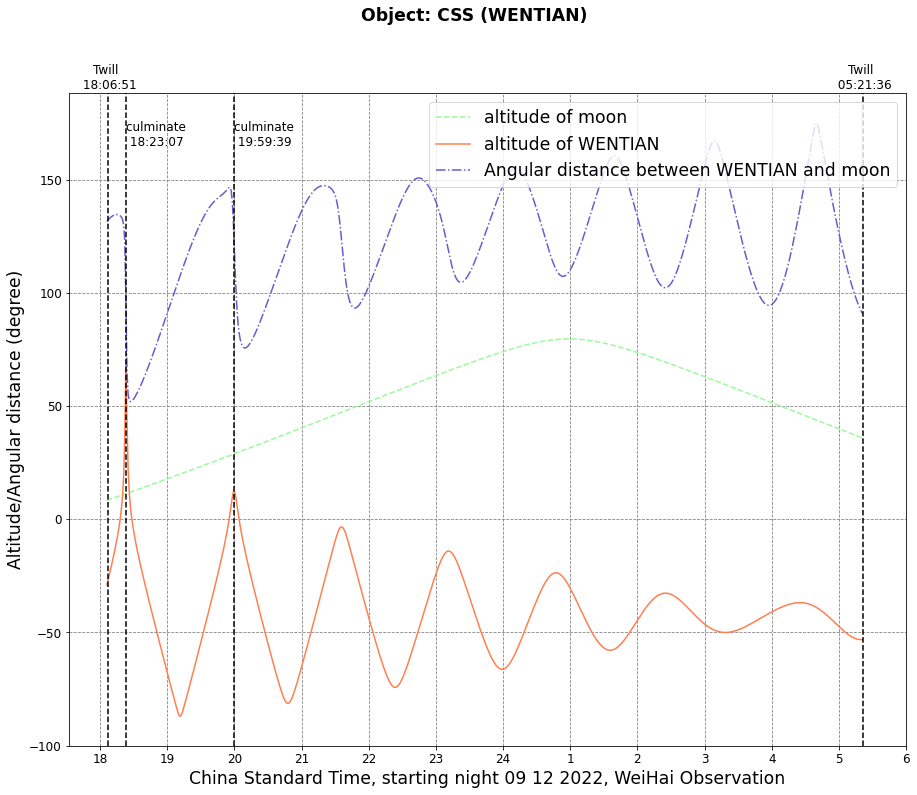

In [39]:
fig, ax = plt.subplots(figsize=(15, 12))
    
ax.plot(timelist_tdb, alt_moon, ls='--', c='palegreen', label='altitude of moon')
ax.plot(timelist_tdb, alt_satellite, ls='-', c='coral', label='altitude of WENTIAN')
ax.plot(timelist_tdb, angle_satellite_moon, ls='-.', c='slateblue', label='Angular distance between WENTIAN and moon')
ax.set_xticks(txtick, sxtick)
ax.grid(ls='--',c='grey')
ax.legend(loc='upper right', fontsize='xx-large')

ax.axvline(As_end.tdb, color='black', ls='--')
ax.axvline(As_sta.tdb, color='black', ls='--')
ax.text(As_end.tdb, 190, "Twill \n {}".format(As_end.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.text(As_sta.tdb, 190, "Twill \n {}".format(As_sta.astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')

ax.axvline(twi_cul_satellite[1].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[1].tdb, 165, "culminate \n {}".format(twi_cul_satellite[1].astimezone(zone).strftime('%H:%M:%S')), ha='left', size='large')
ax.axvline(twi_cul_satellite[4].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[4].tdb, 165, "culminate \n {}".format(twi_cul_satellite[4].astimezone(zone).strftime('%H:%M:%S')), ha='left', size='large')

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

ax.set_xlabel('China Standard Time, starting night 09 12 2022, WeiHai Observation', fontsize='xx-large')
ax.set_ylabel('Altitude/Angular distance (degree)', fontsize='xx-large')

fig.suptitle('Object: CSS (WENTIAN)', fontsize='xx-large', fontweight='bold')

Text(0.5, 0.98, 'Object: CSS (WENTIAN)')

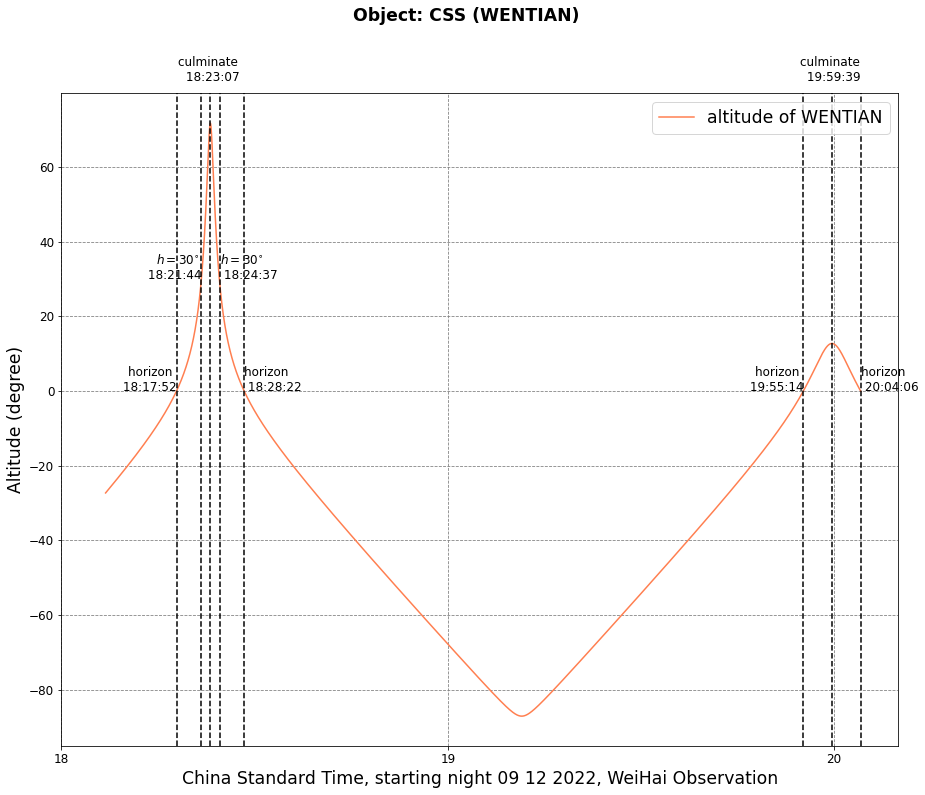

In [40]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.plot(TimeList_tdb, alt_satellite1, ls='-', c='coral', label='altitude of WENTIAN')
ax.grid(ls='--',c='grey')
ax.set_xticks(txtick[0:3], sxtick[0:3])
ax.legend(loc='upper right', fontsize='xx-large')

ax.axvline(twi_cul_satellite[1].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[1].tdb, 83, "culminate \n {}".format(twi_cul_satellite[1].astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')
ax.axvline(twi_cul_satellite[4].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[4].tdb, 83, "culminate \n {}".format(twi_cul_satellite[4].astimezone(zone).strftime('%H:%M:%S')), ha='center', size='large')

string = r'$h = 30^{\circ}$'
ax.axvline(time_satellite[0].tdb, color='black', ls='--')
ax.text(time_satellite[0].tdb, 30, "{} \n {}".format(string, time_satellite[0].astimezone(zone).strftime('%H:%M:%S')), ha='right', size='large')
ax.axvline(time_satellite[2].tdb, color='black', ls='--')
ax.text(time_satellite[2].tdb, 30, "{} \n {}".format(string, time_satellite[2].astimezone(zone).strftime('%H:%M:%S')), ha='left', size='large')

ax.axvline(twi_cul_satellite[3].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[3].tdb, 0, "{} \n {}".format('horizon', twi_cul_satellite[3].astimezone(zone).strftime('%H:%M:%S')), ha='right', size='large')
ax.axvline(twi_cul_satellite[5].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[5].tdb, 0, "{} \n {}".format('horizon', twi_cul_satellite[5].astimezone(zone).strftime('%H:%M:%S')), ha='left', size='large')

ax.axvline(twi_cul_satellite[0].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[0].tdb, 0, "{} \n {}".format('horizon', twi_cul_satellite[0].astimezone(zone).strftime('%H:%M:%S')), ha='right', size='large')
ax.axvline(twi_cul_satellite[2].tdb, color='black', ls='--')
ax.text(twi_cul_satellite[2].tdb, 0, "{} \n {}".format('horizon', twi_cul_satellite[2].astimezone(zone).strftime('%H:%M:%S')), ha='left', size='large')

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

ax.set_xlabel('China Standard Time, starting night 09 12 2022, WeiHai Observation', fontsize='xx-large')
ax.set_ylabel('Altitude (degree)', fontsize='xx-large')

fig.suptitle('Object: CSS (WENTIAN)', fontsize='xx-large', fontweight='bold')

## 问天实验舱过境时间——结果验证

[CSS(WENTIAN)1](https://www.heavens-above.com/passdetails.aspx?lat=37.5359&lng=122.0496&loc=WeiHai&alt=110&tz=ChST&satid=53239&mjd=59922.4327263486&type=A)
.[CSS(WENTIAN)2](https://www.heavens-above.com/passdetails.aspx?lat=37.5359&lng=122.0496&loc=WeiHai&alt=110&tz=ChST&satid=53239&mjd=59922.4997668594&type=A)

[![zgfP0K.png](https://s1.ax1x.com/2022/12/07/zgfP0K.png)](https://imgse.com/i/zgfP0K)

[![zgfCm6.png](https://s1.ax1x.com/2022/12/07/zgfCm6.png)](https://imgse.com/i/zgfCm6)

## 人造卫星地平线以上观测历表

In [41]:
TM1 = TimeSequenceSencond(twi_cul_satellite[0], twi_cul_satellite[2])
TM2 = TimeSequenceSencond(twi_cul_satellite[3], twi_cul_satellite[5])

In [42]:
WenTian_Horizon_eph = {}
for t in TM1:
    alt, az, ra, dec = sat_eph(t)
    WenTian_Horizon_eph[t.astimezone(zone).strftime('%H:%M:%S')] = (alt, az, ra, dec)
for t in TM2:
    alt, az, ra, dec = sat_eph(t)
    WenTian_Horizon_eph[t.astimezone(zone).strftime('%H:%M:%S')] = (alt, az, ra, dec)

In [43]:
print(WenTian_Horizon_eph)

{'18:17:52': (<Angle 00deg 00' 20.3">, <Angle 289deg 02' 41.2">, <Angle 16h 50m 07.26s>, <Angle +15deg 02' 20.1">), '18:17:53': (<Angle 00deg 04' 03.4">, <Angle 289deg 02' 13.3">, <Angle 16h 50m 21.45s>, <Angle +15deg 04' 18.7">), '18:17:54': (<Angle 00deg 07' 47.1">, <Angle 289deg 01' 45.2">, <Angle 16h 50m 35.68s>, <Angle +15deg 06' 17.5">), '18:17:55': (<Angle 00deg 11' 31.6">, <Angle 289deg 01' 16.8">, <Angle 16h 50m 49.97s>, <Angle +15deg 08' 16.5">), '18:17:56': (<Angle 00deg 15' 16.7">, <Angle 289deg 00' 48.2">, <Angle 16h 51m 04.31s>, <Angle +15deg 10' 15.7">), '18:17:57': (<Angle 00deg 19' 02.5">, <Angle 289deg 00' 19.4">, <Angle 16h 51m 18.70s>, <Angle +15deg 12' 15.0">), '18:17:58': (<Angle 00deg 22' 49.1">, <Angle 288deg 59' 50.3">, <Angle 16h 51m 33.15s>, <Angle +15deg 14' 14.6">), '18:17:59': (<Angle 00deg 26' 36.3">, <Angle 288deg 59' 21.0">, <Angle 16h 51m 47.65s>, <Angle +15deg 16' 14.4">), '18:18:00': (<Angle 00deg 30' 24.3">, <Angle 288deg 58' 51.4">, <Angle 16h 52m 

In [44]:
with open('WenTian_Horizon_Eph.txt', 'w') as f:
    f.write('2022-12-9   altitude       azimuth         right ascension   declination \n')
    for t in TM1:
        alt, az, ra, dec = sat_eph(t)
        lines = [t.astimezone(zone).strftime('%H:%M:%S'), str(alt), str(az), str(ra), str(dec)]
        for line in lines:
            f.write(line)
            f.write('   ')
        f.write('\n')
    f.write('\n')
    for t in TM2:
        alt, az, ra, dec = sat_eph(t)
        lines = [t.astimezone(zone).strftime('%H:%M:%S'), str(alt), str(az), str(ra), str(dec)]
        for line in lines:
            f.write(line)
            f.write('   ')
        f.write('\n')